In [2]:
import sys ; sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import librosa 
from scipy.signal import fftconvolve
from scipy import stats
from filterbank import Filterbank

In [3]:
def ploteo(ax, t, signal, label):
    ax.plot(t, signal, label=label)
    ax.legend()

def envelope(signal, time_interval=0.0050):
    #hacer time interval variable por banda
    #time_interval = 0.0050 #10 - 50 ms
    interval = int(time_interval * fs) 
    
    n_windows = len(signal) // interval 
    remainder = len(signal) % interval
    env = np.empty(n_windows)
    for i in range(n_windows):
        env[i] = signal[i*interval:(i+1)*interval].sum()/interval
    env = env / np.max(abs(env))
    t_env = np.arange(0,n_windows*interval, interval)
    return t_env, librosa.amplitude_to_db(env)


def estim_slope(t_env, env, init, end):
    # Solo me interesa el valor de la slope
    init_idx = np.where(env < init)[0][0]
    try:
        end_idx = np.where(env < end)[0][0]
    except:
        end_idx = len(env)-1
    # regresion lineal 
    x = t_env[init_idx:end_idx+1]
    y = env[init_idx:end_idx+1]
    slope, intercept = stats.linregress(x,y)[0:2]
    return intercept, slope , x, y



params = {'fs' : 16000,
          'bands' : [125, 250, 500, 1000, 2000, 4000],
          'bandsize' : 1,
          'order' : 4,
          'f_length': 16384,'power' : True}


# Bloque independiente del proceso. 
signal, fs = librosa.load('../notebooks/rir_aug_database/tr_0.10_num_0000.wav', sr=16000, dtype='float64')

filterbank = Filterbank(**params)
bands = filterbank.apply(signal)
signal = bands[-1]

In [4]:
# CONSTANTES DE DISEÑO
TIME_INTERVAL = 0.005 # [s] from 0.005 to 0.001 
NOISE_FLOOR_DISTANCE = 5 # [dB] from 5 to 10. Level above the noise
INTERVALS = 3 # Intervals per 10 dB of decay. From 3 to 10 for low - high freqs
MARGIN = 5 # Safety margin from cross point. From 5 to 10 dB of decay 
DINAMIC_ABOVE, DINAMIC_BELOW = 10, 5 # Dinamic range of 10-20 dB referred to the noise floor

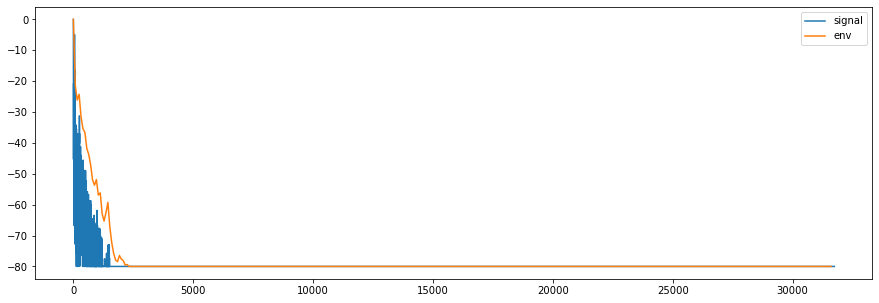

In [5]:
fig, ax = plt.subplots(1, figsize=(15,5))

# acondicionamiento
onset = np.argmax(abs(signal))
signal = signal[onset:]
signal = signal / np.max(abs(signal))

# Respuesta al cuadrado
#signal_sqr = np.power(signal, 2)
signal_sqr = abs(signal)

t = np.arange(0,len(signal_sqr))

# Integracion en intervalos temporales
t_env, env = envelope(signal_sqr, time_interval=TIME_INTERVAL)


ploteo(ax, t, librosa.amplitude_to_db(signal_sqr), 'signal')
ploteo(ax, t_env, env, 'env')
#ax.hlines(noise_level,0,30000, label = 'Piso de ruido', color='g', alpha=0.8)


In [6]:
# Estimacion de piso de ruido con el ultimo 10%
tail = int(len(t_env) * 0.1)
noise_level = env[-tail:].sum() / tail
print('Primer estimacion del piso de ruido: {:.2f} dB'.format(noise_level))


# Estimacion de la pendiente de caida. 
# El left point se pone a 0 dB
# El derecho se pone 5 dB encima del piso de ruido estimado

Primer estimacion del piso de ruido: -80.00 dB


In [7]:
intercept, slope, x_line, y_line = estim_slope(t_env, env, 0, noise_level+NOISE_FLOOR_DISTANCE)
cross_point = (noise_level - intercept) / slope

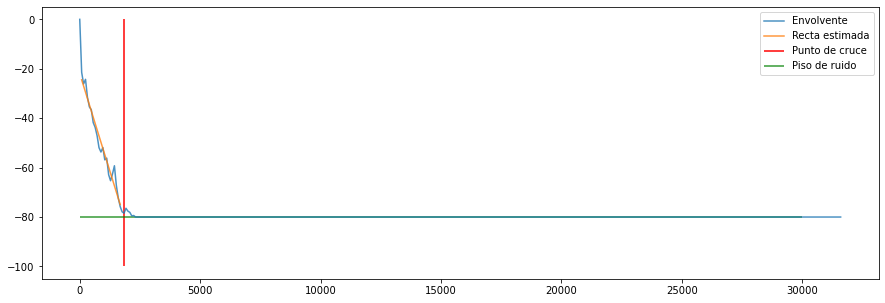

In [8]:
plt.figure(1,figsize=(15,5))
plt.plot(t_env, env, label = 'Envolvente', alpha=0.8)
plt.plot(x_line, (slope*x_line)+intercept, label = 'Recta estimada',alpha=0.8)
plt.vlines(cross_point, -100, 0, color='r', label = 'Punto de cruce')
plt.hlines(noise_level,0,30000, label = 'Piso de ruido', color='g', alpha=0.8)
plt.legend();plt.show()

Nuevo intervalo temporal de: 0.0065625 segundos


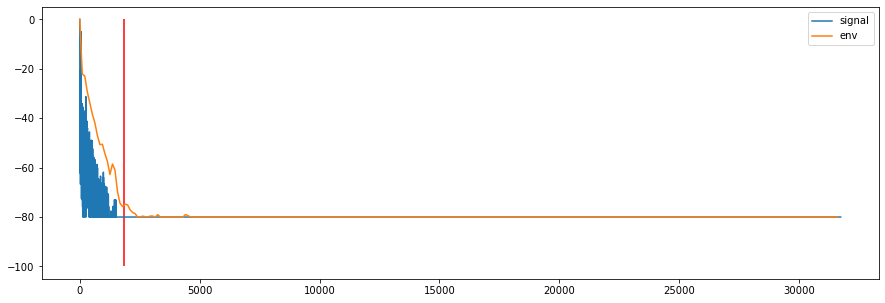

In [9]:
# Encontrar nuevo intervalo temporal. 
# Hacer variar el numero de intervalo por bandas
intervals_per_10dB = INTERVALS #3 - 10 [low - high]
interval_dB = 10 / intervals_per_10dB
interval = int(-interval_dB / slope)
time_interval = interval / fs
print('Nuevo intervalo temporal de: {} segundos'.format(time_interval))

t_env, env= envelope(signal_sqr, time_interval=time_interval)

fig, ax = plt.subplots(1, figsize=(15,5))
ploteo(ax, t, librosa.amplitude_to_db(signal_sqr), 'signal')
ploteo(ax, t_env, env, 'env')
plt.vlines(cross_point, -100, 0, color='r', label = 'Punto de cruce')

In [23]:
######################################### LOOP ##################################################
# Hago una estimacion mas y despues lo pongo dentro de un loop q lo repita 5 veces

# Estimo usando lo que hay 5-10 por debajo del cruce OR el 10% de la señal
margin_cross = MARGIN #5-10dB
safe_cross_point = int(-margin_cross/slope) + int(cross_point)
tail = int(len(t_env) * 0.1)
if (safe_cross_point < t_env[-tail]):
    print('uso el intervalo')
    index_cross = np.where(t_env > safe_cross_point)[0][0]
    noise_level = env[index_cross:].sum() / len(env[index_cross:])
else:
    print('uso la tail')
    noise_level = env[-tail:].sum() / tail
print('Nueva estimacion del piso de ruido de {:.2f} dB'.format(noise_level))


def estim_slope_f(t_env, env, init, end):
    x = t_env[init:end+1]
    y = env[init:end+1]
    slope, intercept = stats.linregress(x,y)[0:2]
    return intercept, slope , x, y


# Estimar la pendiente 5 dB [5-10] encima del pisode ruido para un rango de 10 dB [10-20]

init = (noise_level+DINAMIC_ABOVE - intercept) / slope
init = int(init / (time_interval * fs))
end = (noise_level-DINAMIC_BELOW - intercept) / slope
end = int(end / (time_interval * fs))

intercept_f, slope_f, x_line_f, y_line_f = estim_slope_f(t_env, env, init, end)
cross_point = (noise_level - intercept_f) / slope_f

######################################### LOOP ##################################################

#cross_point = cross_point + onset
#print(cross_point)

uso el intervalo
Nueva estimacion del piso de ruido de -79.98 dB


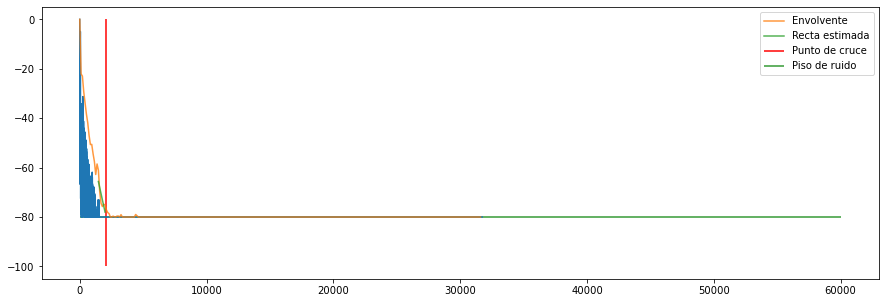

In [24]:
plt.figure(1,figsize=(15,5))
plt.plot(t, librosa.amplitude_to_db(signal_sqr))
plt.plot(t_env, env, label = 'Envolvente', alpha=0.8)
plt.plot(x_line_f, (slope_f*x_line_f)+intercept_f, label = 'Recta estimada',alpha=0.8)
plt.vlines(cross_point,-100, 0, color='r', label = 'Punto de cruce')
plt.hlines(noise_level,0,60000, label = 'Piso de ruido', color='g', alpha=0.8)
plt.legend();plt.show()

In [12]:
cross_point

2078.1307195438912

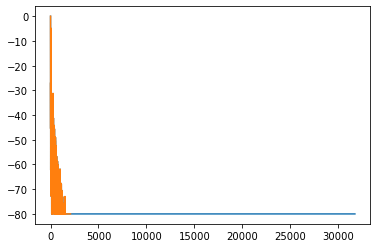

In [13]:
plt.plot(t, librosa.amplitude_to_db(signal_sqr))
plt.plot(t[:int(cross_point)], librosa.amplitude_to_db(signal_sqr[:int(cross_point)]))

In [14]:
def lundeby(signal):
    # CONSTANTES DE DISEÑO
    TIME_INTERVAL = 0.005 # [s] from 0.005 to 0.001 
    NOISE_FLOOR_DISTANCE = 5 # [dB] from 5 to 10. Level above the noise
    INTERVALS = 3 # Intervals per 10 dB of decay. From 3 to 10 for low - high freqs
    MARGIN = 5 # Safety margin from cross point. From 5 to 10 dB of decay 
    DINAMIC_ABOVE, DINAMIC_BELOW = 10, 5 # Dinamic range of 10-20 dB referred to the noise floor
    
    # standarization
    onset = np.argmax(abs(signal))
    signal = signal[onset:]
    signal = signal / np.max(abs(signal))

    # squared response
    #signal_sqr = np.power(signal, 2)
    signal_sqr = abs(signal)
    t = np.arange(0,len(signal_sqr))

    # average smoothing
    t_env, env = envelope(signal_sqr, time_interval=TIME_INTERVAL)
    
    # First estimation of noise floor using the tail (last 10%)
    tail = int(len(t_env) * 0.1)
    noise_level = env[-tail:].sum() / tail
    print('First estimation of noise floor: {:.2f} dB'.format(noise_level))

    intercept, slope, x_line, y_line = estim_slope(t_env, env, 0, noise_level+NOISE_FLOOR_DISTANCE)
    cross_point = (noise_level - intercept) / slope

    # Find new time interval
    intervals_per_10dB = INTERVALS #3 - 10 [low - high]
    interval_dB = 10 / intervals_per_10dB
    interval = int(-interval_dB / slope)
    time_interval = interval / fs
    print('New time interval: {:.4f} seconds'.format(time_interval))

    t_env, env= envelope(signal_sqr, time_interval=time_interval)
    
    for i in range(5):
        margin_cross = MARGIN #5-10dB
        safe_cross_point = int(-margin_cross/slope) + int(cross_point)
        tail = int(len(t_env) * 0.1)
        if (safe_cross_point < t_env[-tail]):
            print('uso el intervalo')
            index_cross = np.where(t_env > safe_cross_point)[0][0]
            noise_level = env[index_cross:].sum() / len(env[index_cross:])
        else:
            print('uso la tail')
            noise_level = env[-tail:].sum() / tail
        print('Nueva estimacion del piso de ruido de {:.2f} dB'.format(noise_level))


        def estim_slope_f(t_env, env, init, end):
            x = t_env[init:end+1]
            y = env[init:end+1]
            slope, intercept = stats.linregress(x,y)[0:2]
            return intercept, slope , x, y


        # Estimar la pendiente 5 dB [5-10] encima del pisode ruido para un rango de 10 dB [10-20]

        init = (noise_level+DINAMIC_ABOVE - intercept) / slope
        init = int(init / (time_interval * fs))
        end = (noise_level-DINAMIC_BELOW - intercept) / slope
        end = int(end / (time_interval * fs))

        intercept_f, slope_f, x_line_f, y_line_f = estim_slope_f(t_env, env, init, end)
        cross_point = (noise_level - intercept_f) / slope_f
    # insert delay samples
    cross_point = cross_point + onset
    return int(cross_point)

First estimation of noise floor: -80.00 dB
New time interval: 0.0597 seconds
uso el intervalo
Nueva estimacion del piso de ruido de -80.00 dB


<ipython-input-14-2cb9aa5174da>:68: RuntimeWarning: invalid value encountered in double_scalars
  cross_point = (noise_level - intercept_f) / slope_f


ValueError: cannot convert float NaN to integer

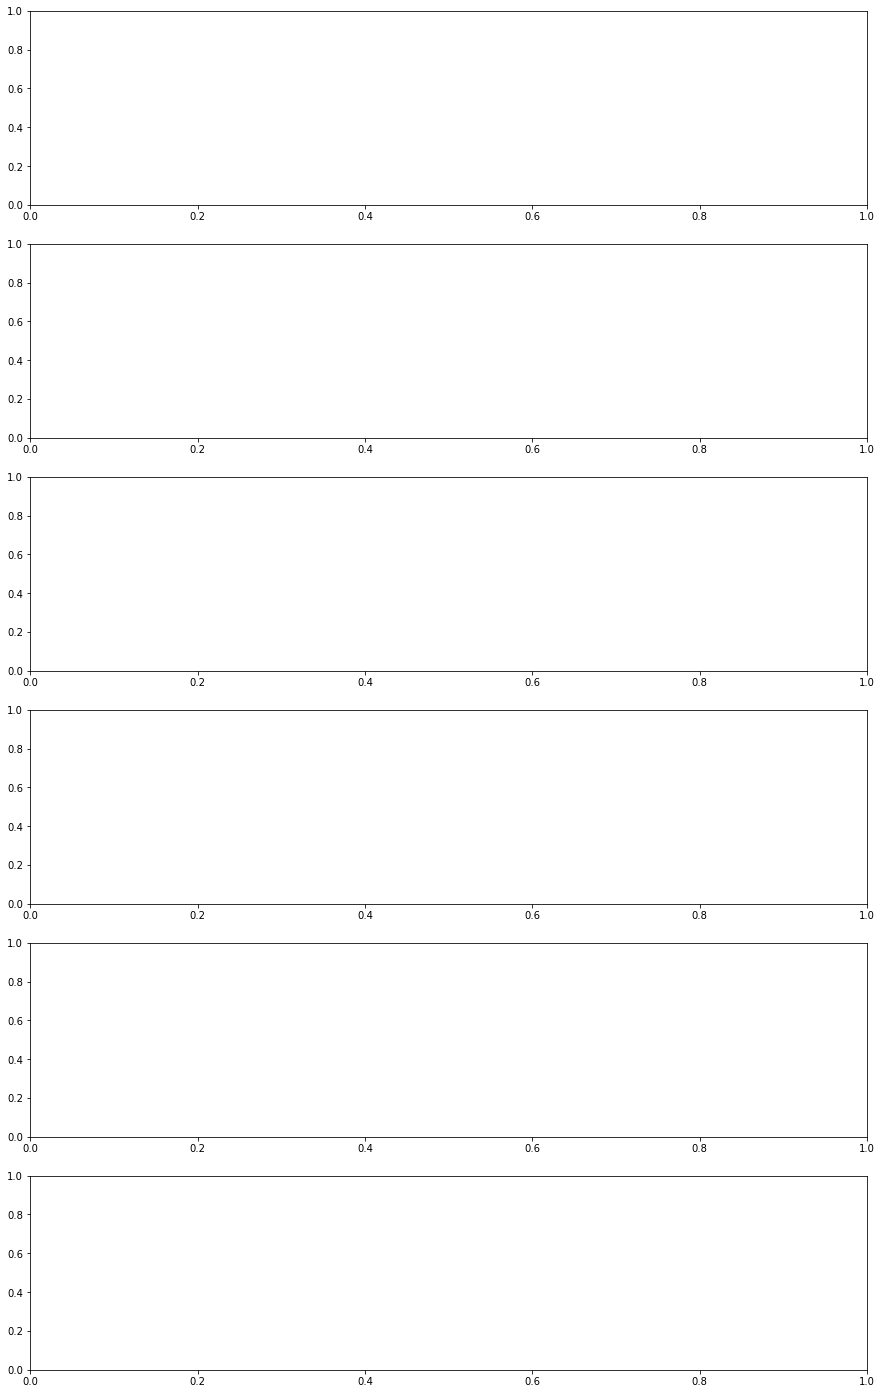

In [15]:
fig, axs = plt.subplots(len(bands), figsize=(15,25))
for idx in range(len(bands)):
    band = bands[idx]
    noise_onset = lundeby(band)
    noiseless = band[:noise_onset]
    axs[idx].plot(librosa.amplitude_to_db(band))
    axs[idx].plot(librosa.amplitude_to_db(noiseless))